# Playground to get acquainted with LLMs

Huggingface playground to manipulate LLMs such as BERT or GPT.

Note that fine-tuning a LLM will come next and is not (yet) included into this notebook. The purpose here is to fully illustrate what a LLM is and how we can manipulate it, as a language model on the one hand and as an encoder to yield contextual embeddings on the other hand.

In [1]:
import torch
import numpy as np

from transformers import AutoModel, AutoModelForCausalLM , AutoTokenizer

/home/kartik/anaconda3/envs/NLPenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Playing with GPT

GPT is a causal transformer encoder trained as a language model. The pre-trained model, along with the corresponding tokenizer, can be directly loaded via the Huggingface library simply by specifying a specific checkpoint (aka model name) such as "gpt2" or "bert-base-uncased". See https://huggingface.co/models for an extensive list of models that can be imported.

Note that Huggingface models often come with the transformer encoder along with the associated "classification head", depending on the class invoked. For instance, AutoModelForCausalLM will yield the model with a LM classification head that predicts a probability distribution function over the vocabulary from the encoded/contextual representation of the tokens at the input. Simply using AutoModel will yield the encoder with no classification head. 

We will use both options in this labwork but you have to be aware that there are other options down there such as AutoModelForSequenceClassification (document classification) or AutoModelForTokenClassification (tagging). We will not use these at this stage (nor at a later stage) to clearly evidence what a classification head is and how it works.

Huggingface documentation on the GPT2 model: https://huggingface.co/docs/transformers/model_doc/gpt2

### Getting acquainted with the model

In [2]:
#
# Loading the transformer encoder as well as the LM classification head that predicts a
# probability distribution over the vocabulary from the token contextual embeddings. The
# model loaded defines the architecture and the weights, both for the encoder and the LM
# classification head.
#
checkpoint = 'gpt2'

tokenizer = AutoTokenizer.from_pretrained(checkpoint) # load tokenizer
print(tokenizer)
print()

#
# print a few things about the model -- can you identify some of the important features such
# as the embedding dimension, the vocabulary size, the maximum authorized sequence length? No 
# worries if you don't understand all the parameters, you're not supposed to anyway. 
# 
# See https://huggingface.co/docs/transformers/model_doc/gpt2#transformers.GPT2Config
#
model = AutoModelForCausalLM.from_pretrained(checkpoint) # load model
print(model.config)

print()
model.eval()

GPT2TokenizerFast(name_or_path='gpt2', vocab_size=50257, model_max_length=1024, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	50256: AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
}
)

GPT2Config {
  "_attn_implementation_autoset": true,
  "_name_or_path": "gpt2",
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 12,
  "n_positions": 1024,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [3]:
#
# Now let's encode a sentence and run it through the model to see what we get out of it
#
# See https://huggingface.co/docs/transformers/model_doc/gpt2#transformers.GPT2LMHeadModel for details
# on the forward function of a GPT2LMHeadModel model.
#

text = 'I enjoy playing with LLMs.'

#
# Let's first have a look at what the tokenizer does.
#
# Question: Why do you think we have an 'attention_mask' attribute at the output of the tokenizer?
# Attention mask tells which words are real and which are padding. It is used to mask the padding tokens. Also it can be used to ignore some words in the input sequence.
inputs = tokenizer(text, return_tensors="pt")
print('Output of tokenizer:\n', inputs)
print('Tokens and text:', tokenizer.convert_ids_to_tokens(inputs['input_ids'][0]), '-->', tokenizer.decode(inputs['input_ids'][0]))

#
# Run tokens through the model
#
# Question: Explain the output that we have 
# The output is the logits of the next token in the sequence. The model predicts the next token in the sequence given the input tokens.
with torch.no_grad():
    outputs = model(**inputs)

print('Output shape:', outputs.logits.shape)

Output of tokenizer:
 {'input_ids': tensor([[   40,  2883,  2712,   351, 27140, 10128,    13]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1]])}
Tokens and text: ['I', 'Ġenjoy', 'Ġplaying', 'Ġwith', 'ĠLL', 'Ms', '.'] --> I enjoy playing with LLMs.
Output shape: torch.Size([1, 7, 50257])


### Looking at token probabilities and generating language

In [4]:
#
# Let's have a look at the LM probabilities
#

#
# get all log-probabilities
#
with torch.no_grad():
    logprobs = torch.nn.LogSoftmax(dim=-1)(outputs.logits)[0]

#
# print LM probabilities for each token in the input
#
ids = inputs['input_ids'][0]
tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

print('LM probabilities for sequence', tokens)
for i in range(len(ids) - 1):
    
    next_token = ids[i+1].item()
    lm_prob = logprobs[i, next_token].item()
    
    print('  P[{}|{}] = {:.6f}'.format(tokens[i+1], ' '.join(tokens[:i+1]), lm_prob))
    
#   
# TODO ::: Find most likely token following with in the input
#


LM probabilities for sequence ['I', 'Ġenjoy', 'Ġplaying', 'Ġwith', 'ĠLL', 'Ms', '.']
  P[Ġenjoy|I] = -9.013782
  P[Ġplaying|I Ġenjoy] = -3.731972
  P[Ġwith|I Ġenjoy Ġplaying] = -1.458015
  P[ĠLL|I Ġenjoy Ġplaying Ġwith] = -11.036862
  P[Ms|I Ġenjoy Ġplaying Ġwith ĠLL] = -7.387120
  P[.|I Ġenjoy Ġplaying Ġwith ĠLL Ms] = -1.864156


In [5]:
#
# Write a prompt completion function based on GPT-2, following the idea of the previous labwork.
#
# For sake of simplicity, we will run the entire sequence through the model at each step rather
# than memorizing previous operations to run only one step as we did for RNNs. In other words, 
# after adding a token to the generated sequence, you will run the entire new sequence through
# the model to get the probabilities for the next token. In practice, there are ways to avoid
# that so as to be much more efficient.
#

def complete_prompt(sentence,model,tokenizer):
    inputs = tokenizer(sentence, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)
        next = torch.argmax(outputs.logits[0][-1])
        next_word = tokenizer.decode(next)
    return next_word

sentence = 'I enjoy playing with'
print('Prompt:', sentence)
print('Next token:', complete_prompt(sentence,model,tokenizer))

for i in range(10):
    sentence += complete_prompt(sentence,model,tokenizer)
    print('Prompt:', sentence)
    



Prompt: I enjoy playing with
Next token:  my
Prompt: I enjoy playing with my
Prompt: I enjoy playing with my friends
Prompt: I enjoy playing with my friends,
Prompt: I enjoy playing with my friends, and
Prompt: I enjoy playing with my friends, and I
Prompt: I enjoy playing with my friends, and I'm
Prompt: I enjoy playing with my friends, and I'm always
Prompt: I enjoy playing with my friends, and I'm always looking
Prompt: I enjoy playing with my friends, and I'm always looking for
Prompt: I enjoy playing with my friends, and I'm always looking for new


### Looking at token embeddings

In [6]:
#
# We can also get the embeddings of the tokens in addition to the output logits
#

text = 'I enjoy playing with LLMs.'

inputs = tokenizer(text, return_tensors="pt")
outputs = model(**inputs, output_hidden_states = True)

print(len(outputs.hidden_states))
print(outputs.hidden_states[0].shape, outputs.hidden_states[0][0][0].shape) # initial embeddings + positional encoding
print(outputs.hidden_states[-1].shape, outputs.hidden_states[-1][0][0].shape) # last layer's embeddings

13
torch.Size([1, 7, 768]) torch.Size([768])
torch.Size([1, 7, 768]) torch.Size([768])


In [7]:
#
# Here are 15 utterances with the token 'rat' with different meanings and morpho-syntactic functions, plus 
# one with the token mouse instrad of rat. 
#
# Writea piece of code to visualize the 16 contextual embeddings in 2D with tSNE.
#

sentences = [
"He decided to rat on his friends to get a lighter sentence.",
"He's quick to rat out his accomplices.",
"She felt betrayed when he went to rat her out to the boss.",
"I can’t believe you would rat on me like that!",
"The suspect threatened to rat if they didn’t offer a deal.",
"A rat scurried across the floor last night.",
"The cat caught a rat in the garden.",
"The rat is often found in urban areas looking for food.",
"I heard a rat squeaking in the walls.",
"The farmer set traps to catch the rat in the barn.",
"He’s a rat for telling the police everything we did.",
"No one trusts him anymore because he's known as a rat.",
"You can’t just rat out your friends like that and expect to be forgiven.",
"She was labeled a rat after giving up the gang’s hideout.",
"He tried to act tough, but everyone knew he was a rat who'd sell anyone out.",
"I heard a mouse squeaking in the walls."
]

#
# tokenize all sentences at once: outputs lists rather than tensors to skirt the padding
# issue. Will have to convert to tensor before passing along to the model though.
#  
inputs = tokenizer(sentences) 

#
# retrieve embeddings of the token 'rat' in all sentences
#
rat_id = tokenizer.encode('a rat is an animal')[1]
mouse_id = tokenizer.encode('a mouse is an animal')[1]

embeddings = np.empty((len(sentences), model.config.n_embd), dtype='float32')

for i in  range(len(sentences)):
    token_id = mouse_id if i == len(sentences) - 1 else rat_id
    
    idx = inputs['input_ids'][i].index(token_id)
    
    with torch.no_grad():
        outputs = model(torch.tensor(inputs['input_ids'][i]), output_hidden_states = True)
    
    embeddings[i,:] = outputs.hidden_states[-1][idx].detach().numpy()
    
    ##### TO COMPLETE ##### --> use .detach().numpy() to get rid of gradients and convert to numpy() array


(16, 2)


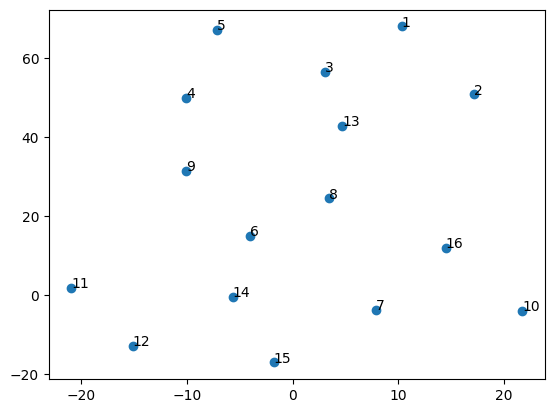

In [8]:
#
# tSNE projection with cosine distance
#

from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

Y = TSNE(n_components=2, metric='cosine', init='random', random_state=0, perplexity=10).fit_transform(embeddings)
print(Y.shape)

plt.scatter(Y[:,0], Y[:,1])
for i in range(len(sentences)):
    plt.annotate(str(i+1), xy=(Y[i,0],Y[i,1]))


## Playing with BERT

BERT is a bidirectional transformer pre-trained with a dual objective: masked language modeling and  next sentence prediction (see course slideware). Similar to GPT2, pre-trained models can be downloaded from the Huggingface library to play with. They might come with a classification head or not, depending on the class used to load them.

In [9]:
checkpoint = 'bert-base-uncased'

tokenizer = AutoTokenizer.from_pretrained(checkpoint) # load tokenizer
print(tokenizer)
print()

#
# print a few things about the model -- can you identify some of the important features such
# as the embedding dimension, the vocabulary size, the maximum authorized sequence length? No 
# worries if you don't understand all the parameters, you're not supposed to anyway. 
# 
# See https://huggingface.co/docs/transformers/model_doc/gpt2#transformers.GPT2Config
#
model = AutoModelForCausalLM.from_pretrained(checkpoint) # load model
print(model.config)

print()
model.eval()

If you want to use `BertLMHeadModel` as a standalone, add `is_decoder=True.`


BertTokenizerFast(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)

BertConfig {
  "_attn_implementation_autoset": true,
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertFo

BertLMHeadModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwi

In [10]:
text = 'I enjoy [MASK] with LLMs.'

inputs = tokenizer(text, return_tensors="pt")
print('Output of tokenizer:\n', inputs)
print('Tokens and text:', tokenizer.convert_ids_to_tokens(inputs['input_ids'][0]), '--', tokenizer.decode(inputs['input_ids'][0]))

with torch.no_grad():
    outputs = model(**inputs)

print('Output shape:', outputs.logits.shape)

Output of tokenizer:
 {'input_ids': tensor([[ 101, 1045, 5959,  103, 2007, 2222, 5244, 1012,  102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1]])}
Tokens and text: ['[CLS]', 'i', 'enjoy', '[MASK]', 'with', 'll', '##ms', '.', '[SEP]'] -- [CLS] i enjoy [MASK] with llms. [SEP]
Output shape: torch.Size([1, 9, 30522])


In [17]:
# Get the logits for the masked token
mask_token_index = torch.where(inputs["input_ids"] == tokenizer.mask_token_id)[1]
mask_token_logits = outputs.logits[0, mask_token_index, :]

# Get the top 10 tokens and their log-probabilities
top_k = 10
top_k_tokens = torch.topk(mask_token_logits, top_k, dim=1)

# Convert token indices to actual tokens
top_k_token_ids = top_k_tokens.indices[0].tolist()
top_k_log_probs = top_k_tokens.values[0].tolist()
top_k_tokens = [tokenizer.decode([token_id]) for token_id in top_k_token_ids]

# Print the results
for token, log_prob in zip(top_k_tokens, top_k_log_probs):
    print(f"Token: {token}, Log-Probability: {log_prob}")

Token: working, Log-Probability: 11.324710845947266
Token: dealing, Log-Probability: 9.325420379638672
Token: studying, Log-Probability: 9.078275680541992
Token: playing, Log-Probability: 8.071203231811523
Token: it, Log-Probability: 7.9164323806762695
Token: being, Log-Probability: 7.7888665199279785
Token: training, Log-Probability: 7.760747909545898
Token: myself, Log-Probability: 7.727956295013428
Token: work, Log-Probability: 7.538906097412109
Token: living, Log-Probability: 7.442696571350098


In [ ]:
#
# What are the 10 most likely tokens for the mask and the corresponding log-probabilities?
#
# Hint: you can use the torch.topk() function to get the top k values and indices
# of a tensor
#




In [22]:
#
# Take the same 15 sentences with token 'rat' (plus th eone with 'mouse'), get the contextual 
# embeddings at the output of the BERT model and plot again. The code is roughly the same as
# for the gtp2 model
#
sentences = [
"He decided to rat on his friends to get a lighter sentence.",
"He's quick to rat out his accomplices.",
"She felt betrayed when he went to rat her out to the boss.",
"I can’t believe you would rat on me like that!",
"The suspect threatened to rat if they didn’t offer a deal.",
"A rat scurried across the floor last night.",
"The cat caught a rat in the garden.",
"The rat is often found in urban areas looking for food.",
"I heard a rat squeaking in the walls.",
"The farmer set traps to catch the rat in the barn.",
"He’s a rat for telling the police everything we did.",
"No one trusts him anymore because he's known as a rat.",
"You can’t just rat out your friends like that and expect to be forgiven.",
"She was labeled a rat after giving up the gang’s hideout.",
"He tried to act tough, but everyone knew he was a rat who'd sell anyone out.",
"I heard a mouse squeaking in the walls."
]

#
# tokenize all sentences at once: outputs lists rather than tensors to skirt the padding
# issue. Will have to convert to tensor before passing along to the model though.
#  
inputs = tokenizer(sentences) 

#
# retrieve embeddings of the token 'rat' in all sentences
#
rat_id = tokenizer.convert_tokens_to_ids('rat')
mouse_id = tokenizer.convert_tokens_to_ids('mouse')

embeddings = np.empty((len(sentences), model.config.hidden_size), dtype='float32')

for i in range(len(sentences)):
    token_id = mouse_id if i == len(sentences) - 1 else rat_id
    
    try:
        idx = inputs['input_ids'][i].index(token_id)
    except ValueError:
        print(f"Token ID {token_id} not found in sentence: {sentences[i]}")
        continue
    
    with torch.no_grad():
        input_ids = torch.tensor(inputs['input_ids'][i]).unsqueeze(0)  # Add batch dimension
        outputs = model(input_ids, output_hidden_states=True)
    
    embeddings[i, :] = outputs.hidden_states[-1][0, idx].detach().numpy()  # Correctly index the output

(16, 2)


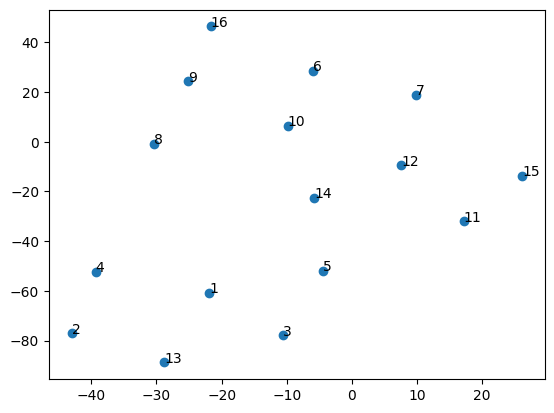

In [23]:
#
# tSNE projection with cosine distance
#

from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

Y = TSNE(n_components=2, metric='cosine', init='random', random_state=0, perplexity=10).fit_transform(embeddings)
print(Y.shape)

plt.scatter(Y[:,0], Y[:,1])
for i in range(len(sentences)):
    plt.annotate(str(i+1), xy=(Y[i,0],Y[i,1]))

## Final note

If you are only interested by the pre-trained encoder, be it a gpt2 encoder or a BERT one, you  can load the models without any classification head, in which case the output directly contains the (contextual) embeddings of the tokens. The following cell for instance illustrate how to do that for a BERT model. In the next lecture, we will use the encoder and the resulting embeddings as part of a neural network architecture and fine-tune the encoder and train the classification elements in the network for a document classification task. 

See https://huggingface.co/transformers/v3.5.1/model_doc/bert.html#bertmodel for details.


In [13]:
model = AutoModel.from_pretrained(checkpoint, add_pooling_layer=False)
print(model.config)

print()
model.eval()

BertConfig {
  "_attn_implementation_autoset": true,
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.47.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}




BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [14]:
text = 'I enjoy playing with LLMs.'

inputs = tokenizer(text, return_tensors="pt")
print('Output of tokenizer:\n', inputs)

with torch.no_grad():
    outputs = model(**inputs)

print('Last hidden states shape:', outputs['last_hidden_state'].shape)


# now you can plug these contextual embeddings into a model... but that's for next (and last) session !

Output of tokenizer:
 {'input_ids': tensor([[ 101, 1045, 5959, 2652, 2007, 2222, 5244, 1012,  102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1]])}
Last hidden states shape: torch.Size([1, 9, 768])
